Dataset simulado criado — linhas: 901
Cesta (cliente x produto) criada — shape: (200, 20)

Top 10 produtos por número de clientes:
Pao_Frances    85
Agua           82
Leite          81
Arroz          76
Feijao         65
Cafe           64
Maca           51
Banana         51
Manteiga       45
Macarrao       45
dtype: int64

Estatísticas itens por cliente:
count    200.000000
mean       4.505000
std        2.310121
min        1.000000
25%        2.000000
50%        5.000000
75%        7.000000
max        8.000000
dtype: float64

Produtos mantidos (>= 3 clientes): 20

Conjuntos frequentes encontrados: 338

Regras encontradas: 215

Top 5 pares mais similares:
('C003', 'C074', np.float64(1.0))
('C007', 'C036', np.float64(1.0))
('C007', 'C119', np.float64(1.0))
('C007', 'C147', np.float64(1.0))
('C010', 'C072', np.float64(1.0))


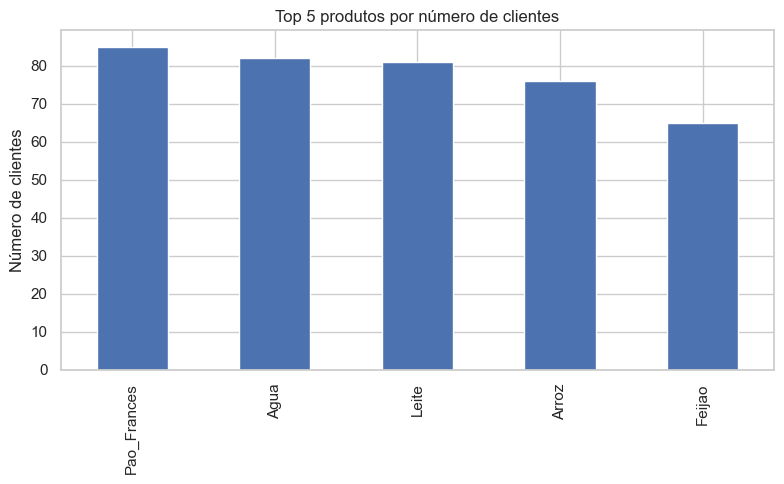

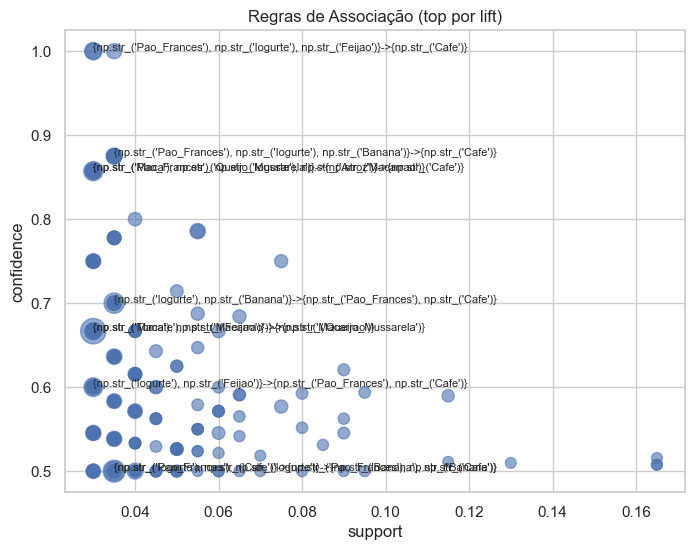

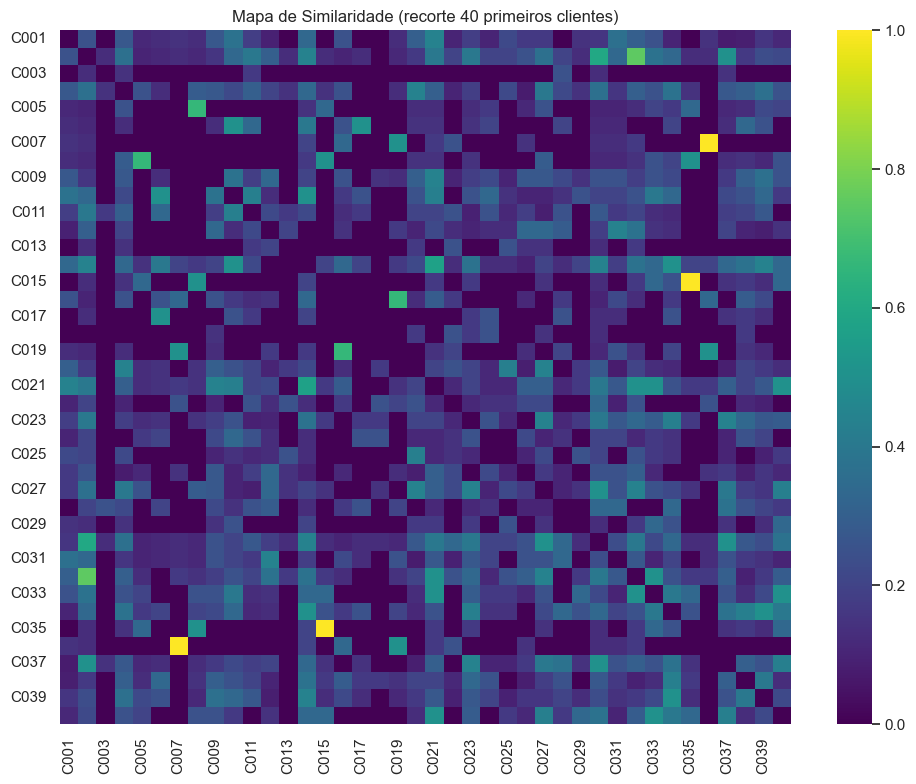


Arquivos gerados: compras_simuladas.csv, cesta_clientes_bool.csv, regras_associacao.csv, similaridade_clientes.csv, clientes_aggregados.csv


'\n- Incluir preprocessing de preços e datas quando disponíveis (ex.: bucketização de preços).\n- Usar FP-Growth por ser mais eficiente em grandes bases.\n- Construir painel interativo com Streamlit para filtrar clientes e visualizar regras.\n- Adicionar recomendação por vizinhança (k-NN) baseada em Jaccard para sugerir top-N produtos.\n- Criar testes e monitoramento de drift nas regras (validação periódica).\n'

In [ ]:
# Projeto_MiniMercado.ipynb
# Código formatado para ser usado em um Jupyter notebook (células separadas por comentários)

# %%
"""
Mini Mercado Inteligente — Notebook
Objetivo: integrar ETL, análise descritiva, mineração de regras (Apriori/FP-Growth),
similaridade (Jaccard) e visualizações em um painel exploratório.

Instruções:
- Rode cada célula em um Jupyter Notebook (ou copie para um .py e use um runner).
- Requer pacotes: pandas, numpy, matplotlib, seaborn, mlxtend, networkx
  Instale com: pip install pandas numpy matplotlib seaborn mlxtend networkx
"""

# %%
# 1) IMPORTS E CONFIG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

sns.set(style="whitegrid")

# %%
# 2) GERAR (OU CARREGAR) DATASET SIMULADO
# Vou gerar um dataset realista de compras: clientes X produtos
np.random.seed(42)
clientes = [f"C{str(i).zfill(3)}" for i in range(1,201)]  # 200 clientes
produtos = [
    'Leite','Pao_Frances','Manteiga','Banana','Cafe','Queijo_Mussarela','Granola',
    'Macarrao','Tomate','Chocolate','Refrigerante','Amendoim','Pao_de_Forma',
    'Arroz','Feijao','Maca','Iogurte','Barra_Cereal','Cha_Verde','Agua'
]

# Probabilidades por produto (alguns mais populares)
popularidade = np.array([0.6,0.55,0.25,0.3,0.35,0.12,0.08,0.25,0.2,0.15,0.18,0.05,0.22,0.4,0.38,0.28,0.12,0.08,0.07,0.5])

transacoes = []
cliente_ids = []
for c in clientes:
    # cada cliente tem entre 1 e 8 produtos distintos
    n = np.random.choice(range(1,9), p=None)
    # amostrar produtos sem reposição com base nas probabilidades (maior prob -> mais chance de ser escolhido)
    probs = popularidade / popularidade.sum()
    itens = list(np.random.choice(produtos, size=n, replace=False, p=probs))
    transacoes.append(itens)
    cliente_ids.append(c)

# Criar DataFrame estilo 'compras.csv'
df_rows = []
for cid, itens in zip(cliente_ids, transacoes):
    for it in itens:
        df_rows.append({'cliente': cid, 'produto': it})

df = pd.DataFrame(df_rows)
# salvar (opcional)
df.to_csv('compras_simuladas.csv', index=False)

print('Dataset simulado criado — linhas:', len(df))

# %%
# 3) ETL — transformar para cesta (one-hot)
# Agregar por cliente (conjunto de produtos)
grupos = df.groupby('cliente')['produto'].apply(set)

# One-hot (matriz cliente x produto)
te = TransactionEncoder()
te_ary = te.fit_transform(transacoes)
mat = pd.DataFrame(te_ary, index=cliente_ids, columns=te.columns_)
# garantir bool
mat = mat.astype(bool)

# Salvar tabela tratada
mat.to_csv('cesta_clientes_bool.csv', index=True)

print('Cesta (cliente x produto) criada — shape:', mat.shape)

# %%
# 4) ANÁLISE DESCRITIVA
# Produtos mais vendidos (contagem de clientes que compraram)
frequencias = mat.sum().sort_values(ascending=False)
print('\nTop 10 produtos por número de clientes:')
print(frequencias.head(10))

# Estatísticas de interesse: número de itens por cliente
itens_por_cliente = mat.sum(axis=1)
print('\nEstatísticas itens por cliente:')
print(itens_por_cliente.describe())

# Criar coluna 'qtd_itens' e salvar versão agregada
df_clientes = pd.DataFrame({'cliente': mat.index, 'qtd_itens': itens_por_cliente})

# %%
# 5) MINERAÇÃO — Apriori / FP-Growth
# Para evitar explosão de memória, limite colunas muito raras
min_ocorrencias = 3
prod_manchas = frequencias[frequencias >= min_ocorrencias].index.tolist()
mat_reduzida = mat[prod_manchas]
print('\nProdutos mantidos (>= {} clientes): {}'.format(min_ocorrencias, len(prod_manchas)))

# Rodar FP-Growth (mais eficiente)
min_support = 0.03  # ajustar conforme tamanho da base
frequent_itemsets = fpgrowth(mat_reduzida, min_support=min_support, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print('\nConjuntos frequentes encontrados:', len(frequent_itemsets))

# Gerar regras
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(by='lift', ascending=False)
print('\nRegras encontradas:', len(rules))

# Salvar regras
rules.to_csv('regras_associacao.csv', index=False)

# %%
# 6) SIMILARIDADE — Jaccard entre clientes
# Reaproveitar 'grupos' criado antes (cliente -> set(produtos))
clientes_sets = grupos.to_dict()

def jaccard(a,b):
    a=set(a)
    b=set(b)
    inter = len(a & b)
    union = len(a | b)
    return inter/union if union>0 else 0

# Matriz de similaridade
clientes_list = list(clientes_sets.keys())
N = len(clientes_list)
sim_mat = pd.DataFrame(np.zeros((N,N)), index=clientes_list, columns=clientes_list)
for i, c1 in enumerate(clientes_list):
    for j, c2 in enumerate(clientes_list):
        if j<=i: continue
        s = jaccard(clientes_sets[c1], clientes_sets[c2])
        sim_mat.loc[c1,c2] = s
        sim_mat.loc[c2,c1] = s

# Salvar
sim_mat.to_csv('similaridade_clientes.csv')

# Top 3 pares mais similares
pairs = []
for i in range(N):
    for j in range(i+1, N):
        pairs.append((clientes_list[i], clientes_list[j], sim_mat.iloc[i,j]))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
print('\nTop 5 pares mais similares:')
for p in pairs_sorted[:5]:
    print(p)

# %%
# 7) VISUALIZAÇÕES — Painel simples (Jupyter)
# 7.1 Top 5 produtos mais vendidos
plt.figure(figsize=(8,5))
frequencias.head(5).plot(kind='bar')
plt.title('Top 5 produtos por número de clientes')
plt.ylabel('Número de clientes')
plt.tight_layout()
plt.show()

# 7.2 Regras de associação mais fortes (por lift) — gráfico scatter support x confidence (tamanho=lift)
if not rules.empty:
    plt.figure(figsize=(8,6))
    plt.scatter(rules['support'], rules['confidence'], s=rules['lift']*50, alpha=0.6)
    for i, row in rules.head(10).iterrows():
        plt.text(row['support'], row['confidence'], f"{set(row['antecedents'])}->{set(row['consequents'])}", fontsize=8)
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.title('Regras de Associação (top por lift)')
    plt.grid(True)
    plt.show()

# 7.3 Mapa de similaridade (heatmap) — mostrar um recorte (ex.: primeiros 40 clientes)
subset = sim_mat.iloc[:40, :40]
plt.figure(figsize=(10,8))
sns.heatmap(subset, cmap='viridis')
plt.title('Mapa de Similaridade (recorte 40 primeiros clientes)')
plt.tight_layout()
plt.show()

# %%
# 8) SALVAR ARTEFATOS E DATAFRAME FINAL
# Salvar DataFrame agregado por cliente com contagem de itens
df_clientes = df_clientes.set_index('cliente')
# adicionar features simples
df_clientes['media_produtos_por_cliente'] = df_clientes['qtd_itens']
# salvar
df_clientes.to_csv('clientes_aggregados.csv')

print('\nArquivos gerados: compras_simuladas.csv, cesta_clientes_bool.csv, regras_associacao.csv, similaridade_clientes.csv, clientes_aggregados.csv')
